### Retrieve sunlight data


In [33]:
# !pip install rioxarray -q

In [34]:
import xarray as xr
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
# import rioxarray as rx
import scipy.stats as ss 

In [35]:
ds = xr.open_dataset('../adaptor.mars.internal-1628422647.5552244-10052-10-6bc58ad9-e69f-43a1-8834-014dc0739c00.nc')
ds

<xarray.Dataset>
Dimensions:    (latitude: 33, longitude: 33, time: 744)
Coordinates:
  * longitude  (longitude) float32 4.0 4.25 4.5 4.75 ... 11.25 11.5 11.75 12.0
  * latitude   (latitude) float32 51.0 50.75 50.5 50.25 ... 43.5 43.25 43.0
  * time       (time) datetime64[ns] 2019-05-01 ... 2019-05-31T23:00:00
Data variables:
    bld        (time, latitude, longitude) float32 ...
    cdir       (time, latitude, longitude) float32 ...
    uvb        (time, latitude, longitude) float32 ...
    ssrd       (time, latitude, longitude) float32 ...
    tsr        (time, latitude, longitude) float32 ...
    tsrc       (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-08-08 11:37:34 GMT by grib_to_netcdf-2.20.0: /opt/ecmw...

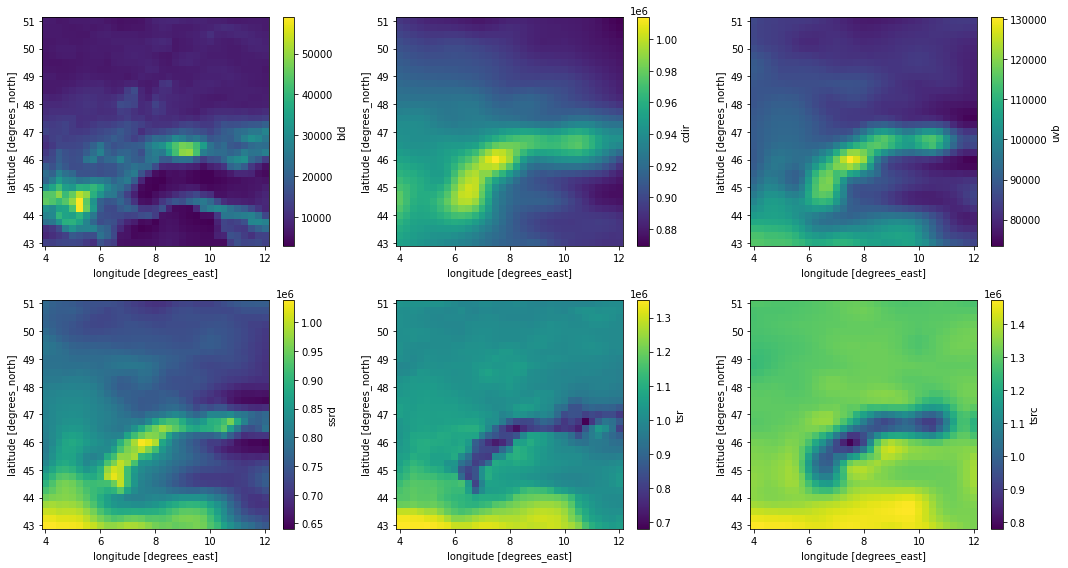

In [36]:
fig, axs = plt.subplots(2,3, figsize=(15,8))

for i, var in enumerate(ds.keys()):
    da = ds[var]
    axs.flatten()[i].set_title(da.long_name)
    da.mean('time').plot(ax=axs.flatten()[i])
    
plt.tight_layout()

In [37]:
nox = xr.open_dataset('../data/nox/coco_hourly_study_region.nc')

In [38]:
ds = ds.sel(longitude=slice(nox.longitude.min(), nox.longitude.max()), latitude=slice(nox.latitude.max(), nox.latitude.min()))

In [39]:
nox = nox.interp(latitude=ds.latitude, longitude=ds.longitude)

In [40]:
merged = xr.merge([ds, nox])
df = merged.to_dataframe()
df = df.dropna()
# df = df.iloc[:2]
df.head()

bld  cdir       uvb  ssrd  \
latitude longitude                                                         
48.75    4.0       2019-05-01 00:00:00  2845.96875   0.0 -0.015625   0.0   
                   2019-05-01 01:00:00  2288.21875   0.0 -0.015625   0.0   
                   2019-05-01 02:00:00  1864.31250   0.0 -0.015625   0.0   
                   2019-05-01 03:00:00  1618.90625   0.0 -0.015625   0.0   
                   2019-05-01 04:00:00  1518.50000   0.0 -0.015625   0.0   

                                          tsr   tsrc  EMISSIONS_2019  
latitude longitude                                                    
48.75    4.0       2019-05-01 00:00:00  0.125 -0.125    3.299342e-12  
                   2019-05-01 01:00:00  0.125 -0.125    2.243552e-12  
                   2019-05-01 02:00:00  0.125 -0.125    1.979605e-12  
                   2019-05-01 03:00:00  0.125 -0.125    1.847631e-12  
                   2019-05-01 04:00:00  0.125 -0.125    2.243552e-12

In [41]:
corr = df.corr().iloc[:-1,-1:]
corr.style.background_gradient(cmap='coolwarm')

,EMISSIONS_2019
bld,-0.034195
cdir,0.184773
uvb,0.165223
ssrd,0.175766
tsr,0.208746
tsrc,0.220867


/opt/conda/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


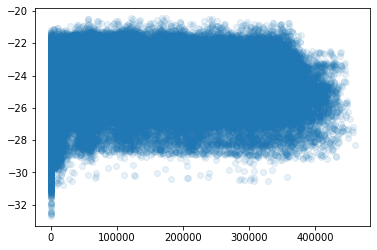

In [42]:
plt.scatter((df.uvb), np.log(df.EMISSIONS_2019), alpha=0.1)

In [43]:
ss.pearsonr((df.uvb), df.EMISSIONS_2019)[0]

0.16522340821171017

___

In [44]:
def spatial_corr(da, variables, time_lag=0):
    '''Return mean spatial correlation coefficient for two variables in Dataset.
       Specify two variables to calculate corr coef. between. '''
    
    assert len(variables) == 2, 'Enter two variables.'
     
    rs = []
    for t in da.time.values:
        da_ = da.sel(time=t)
#         sd = da_.std()[variables[1]].values
        
        
        df_ = da_.to_dataframe()[variables]
        df_ = df_.dropna()
        
        unique = df_.nunique().loc[variables].values
        
        if (unique > 1).sum() == len(variables):
            if len(df_) < 2:
                continue
            else:
                r = ss.pearsonr(df_[variables[0]], df_[variables[1]])[0]
                rs.append((t, r))
        else:
            continue
            
    return pd.DataFrame(rs).rename(columns={0:'time', 1:'r'}).set_index('time')

In [45]:
d = spatial_corr(xr.merge([ds, nox]), variables=['EMISSIONS_2019', 'tsrc'])

<AxesSubplot:xlabel='time'>

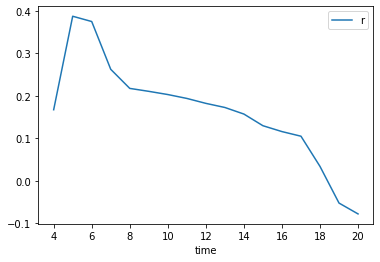

In [46]:
d.groupby(d.index.hour).mean().plot()

___

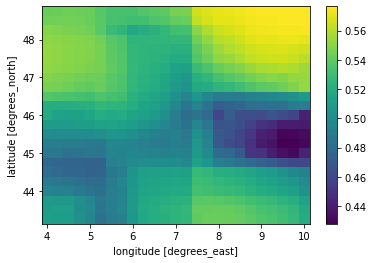

In [47]:
xr.corr(merged['tsrc'], merged['EMISSIONS_2019'], dim='time').plot()